In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import itertools
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

%matplotlib inline
from scipy.spatial.distance import pdist, squareform

In [26]:
number_of_tops = 2
no_of_neighbors = 20

dataset = pd.read_csv(
    r"D:/jupyter/" + str(number_of_tops) + "layers"+str(no_of_neighbors)+"neighbors.csv",
    index_col=[0],
)

from sklearn.model_selection import train_test_split

# next let's split our toy data into training and test sets, choose how much with test_size of the data becomes the test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[0:, 0:-1].values,
    dataset.iloc[0:, -1].values,
    test_size=0.9,
    random_state=86,
)
tops_api = pd.read_csv(r"D:\jupyter\EarlyWSGS\ftunion.csv").fillna(
    0
)  # this file is available in the unconformity or onlap folder in the repo

iterable = ["Kfh", "Klz", "Kll", "Klr", "Kl", "Tfc", "Tfb", "Tfob", "Tfu"]
topcombos = list(zip(iterable, iterable[1:]))
topcombos.append(("Kfh", "Kl"))
topcombos.append(("Kl", "Tfu"))

In [3]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [4]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors' : [1,4,5,11,19,25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],

}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=2, n_jobs =5)
gs_results = gs.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed: 57.1min finished


In [5]:
gs_results.best_score_

0.9999891067538126

In [6]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [7]:
gs_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}

In [27]:
neigh = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [28]:
y_pred = neigh.predict(X_test)

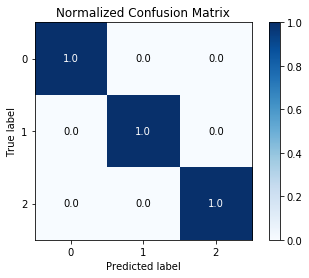

In [29]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.savefig('confusion matrix figure.jpg')

In [11]:
# run this for all combinations of 2 tops and KNN


for j in enumerate(topcombos):
    tops_api = pd.read_csv(r"D:\jupyter\EarlyWSGS\ftunion.csv").fillna(
        0
    )  # this file is available in the unconformity or onlap folder in the repo
    fmtops = list(topcombos[j[0]])
    fmtops.extend(["x", "y"])
    tops = tops_api[fmtops]

    # calculate thicknesses and neighbors for the two tops
    hood = squareform(pdist(tops.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
        selected = (
            tops.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([tops.iloc[:, :-2], frame], axis=1)
    thicknesses = neighborhood.diff(axis=1) * -1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=tops.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = tops[["x", "y"]]
    real_world_log = thicknesses.apply(
        np.log
    )  # take the log of thicknesses for feature engineering
    real_world_pow = thicknesses.apply(
        lambda x: x ** 10
    )  # calculates the power values of thickness for another feature
    rw = (
        pd.concat(
            [thicknesses, real_world_log, real_world_pow, locations],
            axis=1,
            join_axes=[thicknesses.index],
        )
        .dropna()
        .replace(-np.inf, 0)
    )
    normalized_rw = (rw - rw.min()) / (rw.max() - rw.min()).replace(
        0, 0.00001
    )  # normalize the data from 0 to 1
    real_data = normalized_rw.values

    # load up the well location data and merge it with the tops data
    well_locs = pd.read_csv(
        r"D:\jupyter\EarlyWSGS\well_locations.csv", encoding="ISO-8859-1"
    )
    well_preds = neigh.predict(real_data) #knn predictions
    well_prob = neigh.predict_proba(real_data) #knn predictions

    for i in range(len(well_prob)):
        probs.append(well_prob[i].max())
    tops_api["predictionknn"] = well_preds
    tops_api['probability'] = probs
    merged = pd.merge(tops_api, well_locs, on="API")
    plt.scatter(
        merged[merged["predictionknn"] == 0].LON,
        merged[merged["predictionknn"] == 0].LAT,
        label="Angular Unconformity",
    )
    plt.scatter(
        merged[merged["predictionknn"] == 1].LON,
        merged[merged["predictionknn"] == 1].LAT,
        label="Onlap",
    )
    plt.scatter(
        merged[merged["predictionknn"] == 2].LON,
        merged[merged["predictionknn"] == 2].LAT,
        label="Horizontally Stratified",
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title("KNN Predictions")
    plt.savefig(r"D:/predictions/" + str(topcombos[j[0]]) + "_KNN.jpg")
    plt.clf()

    # writes the point data to a shapefile in the dir called data.shp
    geometry = [Point(xy) for xy in zip(merged.LON, merged.LAT)]
    crs = {"init": "epsg:3732"}
    geo_df = GeoDataFrame(merged, crs={"init": "epsg:4326"}, geometry=geometry)
    geo_df.to_file(
        driver="ESRI Shapefile",
        filename="D:/predictions/shapefiles/"
        + str(topcombos[j[0]])
        + "_knn_predictions.shp",
    )

AttributeError: predict_proba is not available when  probability=False